In [16]:
import gensim
import numpy as np
import scipy
import scipy.spatial
import MeCab
import nltk
#nltk.download('punkt')
import xlrd
import string
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

mecab = MeCab.Tagger("-Owakati")

In [82]:
# Select all words in the data file and compute the vocabulary. 
# Write the cross-lingual word embeddings for those words to a separate file.
# This will speed up loading word embeddings and save memory.

data_files = ["../data/newdata.xlsx", "../data/olddata.xlsx", "../data/google_translation.xlsx"]
#data_files = ["../data/newdata.xlsx", "../data/olddata.xlsx"]
vocab = set()
for fname in data_files:
    trans_data = xlrd.open_workbook(fname)
    sheet = trans_data.sheet_by_index(0)  
    for l in range(1, sheet.nrows):
        # tokenise Japanese texts
        rows = sheet.row_values(l, 0, sheet.ncols)
        token_ja = mecab.parse(rows[0].lower())
        vocab = vocab.union(set(token_ja.strip().split()))    
        # tokenise English texts
        vocab = vocab.union(set(nltk.word_tokenize(rows[1].lower())))

stop_words = ['(', ')', '[', ']', '@', '•', '`', '-', '❚❚', '●', '（√',  '×', '。', '＠']
add_words = ['I', 'like', 'hate', 'cat', 'cats', 'dog', 'dogs', 'banana', '好き', '嫌い', '猫', '犬', '私']
vocab = vocab - set(stop_words)
vocab = vocab.union(set(add_words))
print("No of unique words in the vocabulary = %d" % len(vocab))

# write the vocabulary to a file for debugging purposes
with open("../data/vocab.txt", 'w') as vocab_file:
    for word in vocab:
        vocab_file.write("%s\n" % word)

# Lets select the cross-lingual word embeddings for those words in the vocabulary.
cross_in_embeds_fname = "../data/ja2en.txt"
cross_out_embeds_fname = "../data/ja2en.sel"
first_line = True

with open(cross_in_embeds_fname) as cross_in:
    with open(cross_out_embeds_fname, 'w') as cross_out:
        for line in cross_in:
            if first_line:
                dim = int(line.split()[1])
                cross_out.write("%d %d\n" % (len(vocab), dim))
                first_line = False
            elif line.split()[0].lower() in vocab:
                cross_out.write(line)

No of unique words in the vocabulary = 2218


In [83]:
# Load the cross-lingual word embeddings.
large_embeddings = gensim.models.KeyedVectors.load_word2vec_format('../data/ja2en.txt')
small_embeddings = gensim.models.KeyedVectors.load_word2vec_format('../data/ja2en.sel')

In [113]:
embeddings = large_embeddings

In [114]:
def clean_text(s):
    stop_words = ['(', ')', '[', ']', '@', '•', '`', '-', '❚❚', '●', '（√',  '×', '。', '＠']
    for ch in stop_words:
        s = s.replace(ch, ' ')
    return s

In [6]:
def av(source, target):
    # remove words that are not in the vocabulary from source and target.
    source = list(filter(lambda x: x in embeddings, source))
    target = list(filter(lambda x: x in embeddings, target))
    similarity_average = []
    first = []
    second = []
    n = len(source)
    m = len(target)
    for i in range(n):
        first.append(embeddings[source[i]])
    for j in range(m):
        second.append(embeddings[target[j]])
    source_average = np.mean(first, axis=0)
    target_average = np.mean(second, axis=0) 
    #similarity_average = scipy.spatial.distance.cosine(source_average, target_average)
    similarity_average = np.dot(source_average, target_average)/(np.linalg.norm(source_average)*np.linalg.norm(target_average))
    return similarity_average

In [7]:
def sms(source, target):
    source = list(filter(lambda x: x in embeddings, source))
    target = list(filter(lambda x: x in embeddings, target))
    sim_max = []
    
    n = len(source)
    m = len(target)
    
    for i in range(n):
        temp_max = 0
        for j in range(m):
            first, second = embeddings[source[i]],  embeddings[target[j]]   
            #similarity_temp = scipy.spatial.distance.cosine(first, second)
            
            similarity_temp = np.dot(first, second)/(np.linalg.norm(first)*(np.linalg.norm(second)))
            #print("sim_temp", similarity_temp)
            if temp_max < similarity_temp:
                temp_max = similarity_temp
        sim_max.append(temp_max) 
    #sim_max = np.array(sim_max)        
    #print("sim_max", sim_max)
    similarity = np.mean(sim_max, axis=0) 
    return similarity

In [8]:
def wmd(source, target):
    distance = embeddings.wmdistance(source, target)
    return (distance, 0)

In [137]:
def mwmd(source, target):
    # remove words that are not in the vocabulary from source and target.
    source = list(filter(lambda x: x in embeddings, source))
    target = list(filter(lambda x: x in embeddings, target))
     
    n = len(source)
    m = len(target)
    
    # compute distances between words
    C = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            first, second = embeddings[source[i]],  embeddings[target[j]]
            
#             # normalisation
#             first_norm, second_norm = np.linalg.norm(first, ord=1), np.linalg.norm(second, ord=1)
#             if first_norm > 0:
#                 first = first / first_norm
#             if second_norm > 0:
#                 second = second / second_norm
            
            C[i,j] = scipy.spatial.distance.euclidean(first, second)
    
    # Initialise variables
    x = np.zeros(n + n*m, dtype=float)
    T = x[n:].reshape(n,m)
    y = x[:n]
    
    c = np.zeros_like(x)
    c[:n] = 1.0
    
    # Inequality constraints
    b_ub = np.zeros(n*m, dtype=float)
    A_ub = np.zeros((n*m, n + n*m), dtype=float)    
    for p in range(n*m):
        for q in range(n + n*m):
            if p % n == q:
                A_ub[p, q % n] = -1.0
            if (p // n) + 2 * (p % n) + n == q:
                A_ub[p,q] = C[p % n, p // n]    
    #print(A_ub)
    
    # Equality constraints for Eq. 5 (Columns in T must be stochastic)
    CA_eq = np.zeros((n, n + n*m), dtype=float)
    Cb_eq = np.ones(n, dtype=float)
    for p in range(n):
        for q in range(n + m*p, n + m + m*p):
            CA_eq[p,q] = 1.0
            
    # Equality constraints for Eq. 4 (Rows in T must be stochastic)
    RA_eq = np.zeros((m, n + n*m), dtype=float)
    Rb_eq = np.ones(m, dtype=float)
    for p in range(m):
        for q in range(n, n + n*m):
            if p == (q - n) % m:
                RA_eq[p,q] = 1.0
    
    # Double stochasticity
    #A_eq = np.concatenate((CA_eq, RA_eq), axis=0)
    #b_eq = np.concatenate((Cb_eq, Rb_eq), axis=0)    
    
    res = scipy.optimize.linprog(c, A_ub, b_ub, CA_eq, Cb_eq, method='interior-point', options={'maxiter':10000})
    #res = scipy.optimize.linprog(c, A_ub, b_ub, method='simplex') 
    status = {0 : "Optimization terminated successfully",
              1 : "Iteration limit reached",
              2 : "Problem appears to be infeasible",
              3 : "Problem appears to be unbounded",
              4 : "Serious numerical difficulties encountered"}
    if res.status > 0:
        print("\x1b[31m %s \x1b[0m" % status[res.status])
    
    if res.status == 2:
        # Infeasible problem. Drop equality constrains and try again.
        res = scipy.optimize.linprog(c, A_ub, b_ub, method='interior-point') 
        distance_y = np.sum(res.x[:n])
        distance_TC = C.flatten().dot(res.x[n:])
        return (distance_TC, 2)        
    
    if res.status == 0:        
        print("No of iterations to optimisation = %d" % res.nit)
        # objective is the sum of y_i.
        distance_y = np.sum(res.x[:n])
        #print("sum y = ", distance_y)
        distance_TC = C.flatten().dot(res.x[n:])
        #print("sum TC = %f" % distance_TC)
        return (distance_TC, res.status)
    else:
        return (0, res.status) 
    
    

Total number of instances = 30
[('各部名称。（ブレ軽減）ボタン。カッコ内の用語はアイコンを説明している。', 'Camera part; the “anti-shake” button. The term in parentheses is represented by an icon in the manuals except when it appears in the list of camera parts.', 0.30000000000000004), ('各部名称。メニュー操作時では、設定を決定するときに押す。カッコ内の用語はアイコンを説明している。', 'Camera part. Pressing this button applies a selection. The term in parentheses is represented by an icon in the manuals except when it appears in the list of camera parts.', 0.475), ('各部名称。ボタンを押すと表示中の画像を削除する。カッコ内の用語はアイコンを説明している。', 'Camera part. Pressing this button deletes the current picture. The term in parentheses is represented by an icon in the manuals except when it appears in the list of camera parts.', 0.5375)]
No of iterations to optimisation = 10
No of iterations to optimisation = 10
No of iterations to optimisation = 10
No of iterations to optimisation = 10
No of iterations to optimisation = 10
No of iterations to optimisation = 11
No of iterations to optimisation = 11
No of

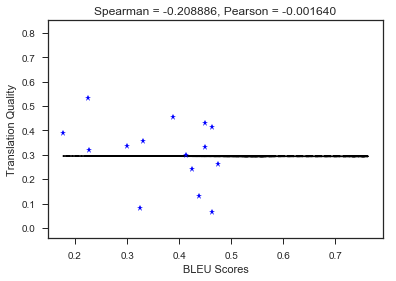

In [138]:
# We will compute the correlation between human ratings and semantic distances over all instances
                     
trans_data = xlrd.open_workbook("../data/olddata.xlsx")  #open the Excel spreadsheet as workbook
sheet = trans_data.sheet_by_index(0)  
instances = []
for l in range(1, sheet.nrows):
    ## tokenise Japanese texts
    rows = sheet.row_values(l, 0, sheet.ncols)
    instances.append((rows[0], rows[1], float(rows[2])))
    
print("Total number of instances = %d" % len(instances))
print(instances[:3])

## 1000 random integers between 0 and 50
human_ratings = []
distancesst = []
distancests = []
bleuScores = []
bad_count = 0

# Evaluate the code in different configurations for mwmd method
for x in instances:
    source = list(set(mecab.parse(clean_text(x[0]).lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(clean_text(x[1]).lower().strip())))
    res = mwmd(source, target)
    if res[1] > 0:
        bad_count += 1
    else:
        distancesst.append(res[0])
        
        # Human ratings
        human_ratings.append(x[2])
        
#         # BLEU scores
#         bleuScores.append(x[2])
        

        
    # Combine both source to target and target to source direction
    # *************************************************************
    target = list(set(mecab.parse(clean_text(x[0]).lower().strip('\n')).split()))
    source = list(set(nltk.word_tokenize(clean_text(x[1]).lower().strip())))
    res1 = mwmd(source, target)
    if res1[1] > 0:
        bad_count += 1
    else:
        distancests.append(res1[0])
        
distancesst = np.array(distancesst)
print("StoT",distancesst)
#print("distances", distances)
print("Source to target failed cases = %d" % bad_count)

distancests = np.array(distancests)
print("TtoS",distancests)
print("Target to source failed cases = %d" % bad_count)
distances = distancesst + distancests
# *************************************************************


#distances = np.array(distancesst)   ## comment this line if using MWMD method and considering both directions

"""
# for average vector, SMS and TMS mehtods
#-----------------------------------------
for x in instances:
    source = list(set(mecab.parse(clean_text(x[0]).lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(clean_text(x[1]).lower().strip())))
    res = av(source, target)
    distancesst.append(res)
    human_ratings.append(x[2])
distances = np.array(distancesst)
#-----------------------------------------
"""
print("original distances", distances)
print(distances.shape)


## convert distances to similarity and scale to [0,1]
human_ratings = np.array(human_ratings)
#bleuScores = np.array(bleuScores)

#--------------comment these two lines----------
# human_ratings = 1.0 - (human_ratings / np.max(human_ratings))
# human_ratings = human_ratings


distances = np.array(distances)
distances = 1.0 - (distances / np.max(distances))  # comment this line if using averagevector and sms

print(human_ratings)
print(human_ratings.shape)
#print(bleuScores)
# print(bleuScores.shape)
print("distances", distances)
print(distances.shape)

spr = scipy.stats.spearmanr(human_ratings, distances)
pearson = scipy.stats.pearsonr(human_ratings, distances)
print("Spearman Full", spr)
print("Pearson Full", pearson)

# Plot linear regression line
fit = np.polyfit(human_ratings, distances, 1)
fit_fn = np.poly1d(fit) 
plt.plot(human_ratings, fit_fn(human_ratings), '--k')

sortinds = np.argsort(human_ratings)
distances = distances[sortinds]
human_ratings = human_ratings[sortinds]
N = len(sortinds) // 2
low_bleu, high_bleu = human_ratings[: N], human_ratings[N:]
low_sim, high_sim = distances[:N], distances[N:]
print("Sperman Low", scipy.stats.spearmanr(low_bleu, low_sim))
print("Sperman High", scipy.stats.spearmanr(high_bleu, high_sim))
print("Pearson Low", scipy.stats.pearsonr(low_bleu, low_sim))
print("Pearson High", scipy.stats.pearsonr(high_bleu, high_sim))

# Compute accuracy. For low_human, predicted value must be less than or equal, 
# and for high_human predicted value must be greater than or equal to be correct.

corrects = 0
for (x,y) in zip(low_bleu, low_sim):
    if fit_fn(x) >= y:
        corrects += 1
for (x,y) in zip(high_bleu, high_sim):
    if fit_fn(x) <= y:
        corrects += 1
print("Accuracy = ", float(100 * corrects) / float(len(distances)))
plt.plot(low_bleu, low_sim, 'b*', high_bleu, high_sim, 'r+')
plt.xlabel("BLEU Scores")
plt.ylabel("Translation Quality")
plt.title("Spearman = %f, Pearson = %f" % (spr[0], pearson[0]))
plt.show()


In [79]:
# We provide a simple UI for entering source (Japanese) and target (English) texts to compare.

def Comparison(Source_Ja, Target_En):
    source = list(set(mecab.parse(Source_Ja.lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(Target_En.lower().strip())))
    print(source, target)
    distance = mwmd(source, target)[0]
    print("Semantic distance = %f\n" % distance)

interact_manual(Comparison, Source_Ja='私は猫が好きです', Target_En="I like cats");

A Jupyter Widget

In [ ]:
# Process a dataset, predict similarities and save to a file.
trans_data = xlrd.open_workbook('../data/newdata.xlsx')  
sheet = trans_data.sheet_by_index(0)  
scores = []
outputs = []
distancesst = []
distancests = []
for l in range(1, sheet.nrows):
    rows = sheet.row_values(l, 0, sheet.ncols)
    source = list(set(mecab.parse(clean_text(rows[0]).lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(clean_text(rows[1]).lower().strip())))
    #res1 = sms(source, target)
    #distancesst.append(res1)
    res1 = mwmd(source, target)
    vals_t = -1 if res1[1] > 0 else res1[0]
    distancesst.append(vals_t)
    
    res2 = mwmd(target, source)
    valt_s = -1 if res2[1] > 0 else res2[0]
    distancests.append(valt_s)

distancesst = np.array(distancesst)
distancests = np.array(distancests)
print("stot",distancesst)
print("ttos",distancests)
scores = distancesst + distancests
#scores = distancesst

"""
    scores.append(val)
    print("val", val)
    
"""  
np.savetxt("../data/distances.csv", scores)
#scores = np.array(scores)
max_val = np.max(scores)
print("max val", max_val)
scores = 1.0 - (scores / max_val)
"""
avg_val = np.average(scores)
scores = (scores * 0.85) / avg_val
"""
with open("../data/pred-sims-newdata.csv", "w") as out_file:
    for val in scores:
        #print(val)
        out_file.write("%f\n" % val)

TODO:
-	L2 normalised, l1 normalised vs. non-normalised (3 options)
-	Y_sum vs TC_sum (2 options)
-	Full vocabulary vs. restricted vocabulary (2 options)
-	Row stochasticity, column stochasticity (2 options)

- Do 3 x 2 x 2 x 2 = 24 experiments and produce the correlation plots. Prepare a table summarising the results (Spearman, Pearson for Full, High and Low, and accuracy)
24 rows and 7 columns excel sheet!
Decide which setting is the best.

* Once the answer to this question is known, we will score the newdataset using wmd and the best version of the proposed method and get humans to judge.
